# Downloading and Prepping Data <a id="2"></a>

Import Primary Modules:

In [4]:
import numpy as np  # useful for many scientific computing in Python
import pandas as pd # primary data structure library
from PIL import Image # converting images into arrays

Let's download and import our primary Canadian Immigration dataset using *pandas* `read_excel()` method. Normally, before we can do that, we would need to download a module which *pandas* requires to read in excel files. This module is **xlrd**. For your convenience, we have pre-installed this module, so you would not have to worry about that. Otherwise, you would need to run the following line of code to install the **xlrd** module:
```
!conda install -c anaconda xlrd --yes
```

In [6]:
!conda install -c anaconda xlrd --yes

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.5.11
  latest version: 4.7.10

Please update conda by running

    $ conda update -n base -c defaults conda



## Package Plan ##

  environment location: /home/jupyterlab/conda/envs/python

  added / updated specs: 
    - xlrd


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    openssl-1.0.2s             |       h7b6447c_0         3.1 MB  anaconda
    certifi-2019.6.16          |           py36_0         154 KB  anaconda
    xlrd-1.2.0                 |           py36_0         188 KB  anaconda
    ------------------------------------------------------------
                                           Total:         3.5 MB

The following packages will be UPDATED:

    openssl: 1.0.2r-h14c3975_0 conda-forge --> 1.0.2s-h7b6447c_0 anaconda
    xlrd:    1.1.0-py37_1                  --> 1.2.0-py3

Download the dataset and read it into a *pandas* dataframe:

In [7]:
df_can = pd.read_excel('https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/DV0101EN/labs/Data_Files/Canada.xlsx',
                       sheet_name='Canada by Citizenship',
                       skiprows=range(20),
                       skipfooter=2)

print('Data downloaded and read into a dataframe!')

Data downloaded and read into a dataframe!


Let's take a look at the first five items in our dataset

In [8]:
df_can.head()

,Type,Coverage,OdName,AREA,AreaName,REG,RegName,DEV,DevName,1980,...,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013
0,Immigrants,Foreigners,Afghanistan,935,Asia,5501,Southern Asia,902,Developing regions,16,...,2978,3436,3009,2652,2111,1746,1758,2203,2635,2004
1,Immigrants,Foreigners,Albania,908,Europe,925,Southern Europe,901,Developed regions,1,...,1450,1223,856,702,560,716,561,539,620,603
2,Immigrants,Foreigners,Algeria,903,Africa,912,Northern Africa,902,Developing regions,80,...,3616,3626,4807,3623,4005,5393,4752,4325,3774,4331
3,Immigrants,Foreigners,American Samoa,909,Oceania,957,Polynesia,902,Developing regions,0,...,0,0,1,0,0,0,0,0,0,0
4,Immigrants,Foreigners,Andorra,908,Europe,925,Southern Europe,901,Developed regions,0,...,0,0,1,1,0,0,0,0,1,1


Let's find out how many entries there are in our dataset

In [9]:
# print the dimensions of the dataframe
print(df_can.shape)

(195, 43)


Clean up data. We will make some modifications to the original dataset to make it easier to create our visualizations. Refer to *Introduction to Matplotlib and Line Plots* and *Area Plots, Histograms, and Bar Plots* for a detailed description of this preprocessing.

In [10]:
# clean up the dataset to remove unnecessary columns (eg. REG) 
df_can.drop(['AREA','REG','DEV','Type','Coverage'], axis = 1, inplace = True)

# let's rename the columns so that they make sense
df_can.rename (columns = {'OdName':'Country', 'AreaName':'Continent','RegName':'Region'}, inplace = True)

# for sake of consistency, let's also make all column labels of type string
df_can.columns = list(map(str, df_can.columns))

# set the country name as index - useful for quickly looking up countries using .loc method
df_can.set_index('Country', inplace = True)

# add total column
df_can['Total'] =  df_can.sum (axis = 1)

# years that we will be using in this lesson - useful for plotting later on
years = list(map(str, range(1980, 2014)))
print ('data dimensions:', df_can.shape)

data dimensions: (195, 38)


# Visualizing Data using Matplotlib<a id="4"></a>

Import `matplotlib`:

In [11]:
%matplotlib inline

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches # needed for waffle Charts

mpl.style.use('ggplot') # optional: for ggplot-like style

# check for latest version of Matplotlib
print ('Matplotlib version: ', mpl.__version__) # >= 2.0.0

Matplotlib version:  3.1.1


# Waffle Charts <a id="6"></a>


A `waffle chart` is an interesting visualization that is normally created to display progress toward goals. It is commonly an effective option when you are trying to add interesting visualization features to a visual that consists mainly of cells, such as an Excel dashboard.

Let's revisit the previous case study about Denmark, Norway, and Sweden.

In [12]:
# let's create a new dataframe for these three countries 
df_dsn = df_can.loc[['Denmark', 'Norway', 'Sweden'], :]

# let's take a look at our dataframe
df_dsn

,Continent,Region,DevName,1980,1981,1982,1983,1984,1985,1986,...,2005,2006,2007,2008,2009,2010,2011,2012,2013,Total
Country,,,,,,,,,,,,,,,,,,,,,
Denmark,Europe,Northern Europe,Developed regions,272,293,299,106,93,73,93,...,62,101,97,108,81,92,93,94,81,3901
Norway,Europe,Northern Europe,Developed regions,116,77,106,51,31,54,56,...,57,53,73,66,75,46,49,53,59,2327
Sweden,Europe,Northern Europe,Developed regions,281,308,222,176,128,158,187,...,205,139,193,165,167,159,134,140,140,5866


Unfortunately, unlike R, `waffle` charts are not built into any of the Python visualization libraries. Therefore, we will learn how to create them from scratch.

**Step 1.** The first step into creating a waffle chart is determing the proportion of each category with respect to the total.

In [13]:
# compute the proportion of each category with respect to the total
total_values = sum(df_dsn['Total'])
category_proportions = [(float(value) / total_values) for value in df_dsn['Total']]

# print out proportions
for i, proportion in enumerate(category_proportions):
    print (df_dsn.index.values[i] + ': ' + str(proportion))

Denmark: 0.32255663965602777
Norway: 0.1924094592359848
Sweden: 0.48503390110798744


**Step 2.** The second step is defining the overall size of the `waffle` chart.

In [14]:
width = 40 # width of chart
height = 10 # height of chart

total_num_tiles = width * height # total number of tiles

print ('Total number of tiles is ', total_num_tiles)

Total number of tiles is  400


**Step 3.** The third step is using the proportion of each category to determe it respective number of tiles

In [15]:
# compute the number of tiles for each catagory
tiles_per_category = [round(proportion * total_num_tiles) for proportion in category_proportions]

# print out number of tiles per category
for i, tiles in enumerate(tiles_per_category):
    print (df_dsn.index.values[i] + ': ' + str(tiles))

Denmark: 129
Norway: 77
Sweden: 194


Based on the calculated proportions, Denmark will occupy 129 tiles of the `waffle` chart, Norway will occupy 77 tiles, and Sweden will occupy 194 tiles.

**Step 4.** The fourth step is creating a matrix that resembles the `waffle` chart and populating it.

In [16]:
# initialize the waffle chart as an empty matrix
waffle_chart = np.zeros((height, width))

# define indices to loop through waffle chart
category_index = 0
tile_index = 0

# populate the waffle chart
for col in range(width):
    for row in range(height):
        tile_index += 1

        # if the number of tiles populated for the current category is equal to its corresponding allocated tiles...
        if tile_index > sum(tiles_per_category[0:category_index]):
            # ...proceed to the next category
            category_index += 1       
            
        # set the class value to an integer, which increases with class
        waffle_chart[row, col] = category_index
        
print ('Waffle chart populated!')

Waffle chart populated!


Let's take a peek at how the matrix looks like.

In [17]:
waffle_chart

array([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 2., 2., 2.,
        2., 2., 2., 2., 2., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.,
        3., 3., 3., 3., 3., 3., 3., 3.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 2., 2., 2.,
        2., 2., 2., 2., 2., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.,
        3., 3., 3., 3., 3., 3., 3., 3.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 2., 2., 2.,
        2., 2., 2., 2., 2., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.,
        3., 3., 3., 3., 3., 3., 3., 3.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 2., 2., 2.,
        2., 2., 2., 2., 2., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.,
        3., 3., 3., 3., 3., 3., 3., 3.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 2., 2., 2.,
        2., 2., 2., 2., 2., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.,
        3., 3., 3., 3., 3., 3., 3., 3.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 2., 2., 2.,
   

As expected, the matrix consists of three categories and the total number of each category's instances matches the total number of tiles allocated to each category.

**Step 5.** Map the `waffle` chart matrix into a visual.

<Figure size 432x288 with 0 Axes>

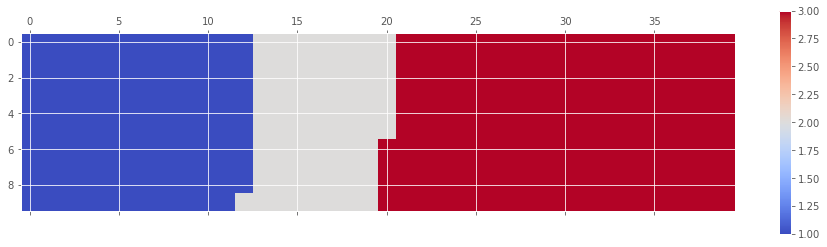

In [18]:
# instantiate a new figure object
fig = plt.figure()

# use matshow to display the waffle chart
colormap = plt.cm.coolwarm
plt.matshow(waffle_chart, cmap=colormap)
plt.colorbar()

**Step 6.** Prettify the chart.

([], <a list of 0 Text yticklabel objects>)

<Figure size 432x288 with 0 Axes>

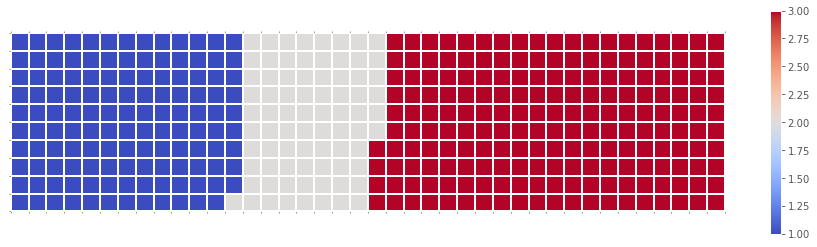

In [19]:
# instantiate a new figure object
fig = plt.figure()

# use matshow to display the waffle chart
colormap = plt.cm.coolwarm
plt.matshow(waffle_chart, cmap=colormap)
plt.colorbar()

# get the axis
ax = plt.gca()

# set minor ticks
ax.set_xticks(np.arange(-.5, (width), 1), minor=True)
ax.set_yticks(np.arange(-.5, (height), 1), minor=True)
    
# add gridlines based on minor ticks
ax.grid(which='minor', color='w', linestyle='-', linewidth=2)

plt.xticks([])
plt.yticks([])

**Step 7.** Create a legend and add it to chart.

<Figure size 432x288 with 0 Axes>

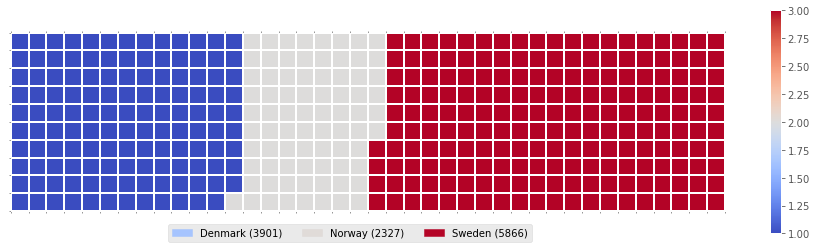

In [20]:
# instantiate a new figure object
fig = plt.figure()

# use matshow to display the waffle chart
colormap = plt.cm.coolwarm
plt.matshow(waffle_chart, cmap=colormap)
plt.colorbar()

# get the axis
ax = plt.gca()

# set minor ticks
ax.set_xticks(np.arange(-.5, (width), 1), minor=True)
ax.set_yticks(np.arange(-.5, (height), 1), minor=True)
    
# add gridlines based on minor ticks
ax.grid(which='minor', color='w', linestyle='-', linewidth=2)

plt.xticks([])
plt.yticks([])

# compute cumulative sum of individual categories to match color schemes between chart and legend
values_cumsum = np.cumsum(df_dsn['Total'])
total_values = values_cumsum[len(values_cumsum) - 1]

# create legend
legend_handles = []
for i, category in enumerate(df_dsn.index.values):
    label_str = category + ' (' + str(df_dsn['Total'][i]) + ')'
    color_val = colormap(float(values_cumsum[i])/total_values)
    legend_handles.append(mpatches.Patch(color=color_val, label=label_str))

# add legend to chart
plt.legend(handles=legend_handles,
           loc='lower center', 
           ncol=len(df_dsn.index.values),
           bbox_to_anchor=(0., -0.2, 0.95, .1)
          )

And there you go! What a good looking *delicious* `waffle` chart, don't you think?

Now it would very inefficient to repeat these seven steps every time we wish to create a `waffle` chart. So let's combine all seven steps into one function called *create_waffle_chart*. This function would take the following parameters as input:

> 1. **categories**: Unique categories or classes in dataframe.
> 2. **values**: Values corresponding to categories or classes.
> 3. **height**: Defined height of waffle chart.
> 4. **width**: Defined width of waffle chart.
> 5. **colormap**: Colormap class
> 6. **value_sign**: In order to make our function more generalizable, we will add this parameter to address signs that could be associated with a value such as %, $, and so on. **value_sign** has a default value of empty string.

In [21]:
def create_waffle_chart(categories, values, height, width, colormap, value_sign=''):

    # compute the proportion of each category with respect to the total
    total_values = sum(values)
    category_proportions = [(float(value) / total_values) for value in values]

    # compute the total number of tiles
    total_num_tiles = width * height # total number of tiles
    print ('Total number of tiles is', total_num_tiles)
    
    # compute the number of tiles for each catagory
    tiles_per_category = [round(proportion * total_num_tiles) for proportion in category_proportions]

    # print out number of tiles per category
    for i, tiles in enumerate(tiles_per_category):
        print (df_dsn.index.values[i] + ': ' + str(tiles))
    
    # initialize the waffle chart as an empty matrix
    waffle_chart = np.zeros((height, width))

    # define indices to loop through waffle chart
    category_index = 0
    tile_index = 0

    # populate the waffle chart
    for col in range(width):
        for row in range(height):
            tile_index += 1

            # if the number of tiles populated for the current category 
            # is equal to its corresponding allocated tiles...
            if tile_index > sum(tiles_per_category[0:category_index]):
                # ...proceed to the next category
                category_index += 1       
            
            # set the class value to an integer, which increases with class
            waffle_chart[row, col] = category_index
    
    # instantiate a new figure object
    fig = plt.figure()

    # use matshow to display the waffle chart
    colormap = plt.cm.coolwarm
    plt.matshow(waffle_chart, cmap=colormap)
    plt.colorbar()

    # get the axis
    ax = plt.gca()

    # set minor ticks
    ax.set_xticks(np.arange(-.5, (width), 1), minor=True)
    ax.set_yticks(np.arange(-.5, (height), 1), minor=True)
    
    # add dridlines based on minor ticks
    ax.grid(which='minor', color='w', linestyle='-', linewidth=2)

    plt.xticks([])
    plt.yticks([])

    # compute cumulative sum of individual categories to match color schemes between chart and legend
    values_cumsum = np.cumsum(values)
    total_values = values_cumsum[len(values_cumsum) - 1]

    # create legend
    legend_handles = []
    for i, category in enumerate(categories):
        if value_sign == '%':
            label_str = category + ' (' + str(values[i]) + value_sign + ')'
        else:
            label_str = category + ' (' + value_sign + str(values[i]) + ')'
            
        color_val = colormap(float(values_cumsum[i])/total_values)
        legend_handles.append(mpatches.Patch(color=color_val, label=label_str))

    # add legend to chart
    plt.legend(
        handles=legend_handles,
        loc='lower center', 
        ncol=len(categories),
        bbox_to_anchor=(0., -0.2, 0.95, .1)
    )

Now to create a `waffle` chart, all we have to do is call the function `create_waffle_chart`. Let's define the input parameters:

In [22]:
width = 40 # width of chart
height = 10 # height of chart

categories = df_dsn.index.values # categories
values = df_dsn['Total'] # correponding values of categories

colormap = plt.cm.coolwarm # color map class

And now let's call our function to create a `waffle` chart.

Total number of tiles is 400
Denmark: 129
Norway: 77
Sweden: 194


<Figure size 432x288 with 0 Axes>

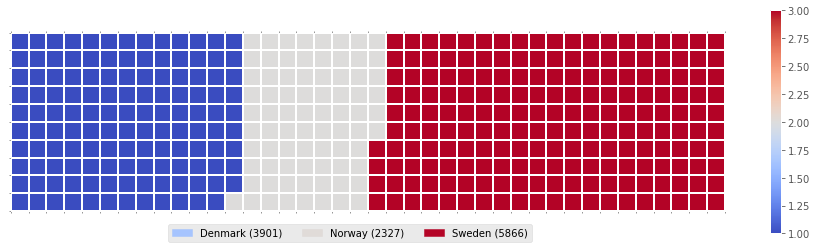

In [23]:
create_waffle_chart(categories, values, height, width, colormap)

There seems to be a new Python package for generating `waffle charts` called [PyWaffle](https://github.com/ligyxy/PyWaffle), but it looks like the repository is still being built. But feel free to check it out and play with it.

# Word Clouds <a id="8"></a>


`Word` clouds (also known as text clouds or tag clouds) work in a simple way: the more a specific word appears in a source of textual data (such as a speech, blog post, or database), the bigger and bolder it appears in the word cloud.

Luckily, a Python package already exists in Python for generating `word` clouds. The package, called `word_cloud` was developed by **Andreas Mueller**. You can learn more about the package by following this [link](https://github.com/amueller/word_cloud/).

Let's use this package to learn how to generate a word cloud for a given text document.

First, let's install the package.

In [24]:
# install wordcloud
!conda install -c conda-forge wordcloud==1.4.1 --yes

# import package and its set of stopwords
from wordcloud import WordCloud, STOPWORDS

print ('Wordcloud is installed and imported!')

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.5.11
  latest version: 4.7.10

Please update conda by running

    $ conda update -n base -c defaults conda



## Package Plan ##

  environment location: /home/jupyterlab/conda/envs/python

  added / updated specs: 
    - wordcloud==1.4.1


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    wordcloud-1.4.1            |           py36_0         324 KB  conda-forge

The following NEW packages will be INSTALLED:

    wordcloud: 1.4.1-py36_0      conda-forge

The following packages will be UPDATED:

    certifi:   2019.6.16-py36_0  anaconda    --> 2019.6.16-py36_1  conda-forge

The following packages will be DOWNGRADED:

    openssl:   1.0.2s-h7b6447c_0 anaconda    --> 1.0.2r-h14c3975_0 conda-forge


wordcloud-1.4.1      | 324 KB    | ##################################### | 100% 
Preparing transa

`Word` clouds are commonly used to perform high-level analysis and visualization of text data. Accordinly, let's digress from the immigration dataset and work with an example that involves analyzing text data. Let's try to analyze a short novel written by **Lewis Carroll** titled *Alice's Adventures in Wonderland*. Let's go ahead and download a _.txt_ file of the novel.

In [25]:
# download file and save as alice_novel.txt
!wget --quiet https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/DV0101EN/labs/Data_Files/alice_novel.txt

# open the file and read it into a variable alice_novel
alice_novel = open('alice_novel.txt', 'r').read()
    
print ('File downloaded and saved!')

File downloaded and saved!


Next, let's use the stopwords that we imported from `word_cloud`. We use the function *set* to remove any redundant stopwords.

In [26]:
stopwords = set(STOPWORDS)

Create a word cloud object and generate a word cloud. For simplicity, let's generate a word cloud using only the first 2000 words in the novel.

In [27]:
# instantiate a word cloud object
alice_wc = WordCloud(
    background_color='white',
    max_words=2000,
    stopwords=stopwords
)

# generate the word cloud
alice_wc.generate(alice_novel)

Awesome! Now that the `word` cloud is created, let's visualize it.

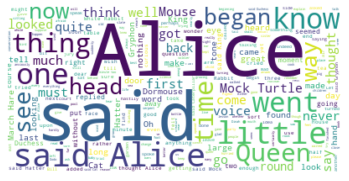

In [28]:
# display the word cloud
plt.imshow(alice_wc, interpolation='bilinear')
plt.axis('off')
plt.show()

Interesting! So in the first 2000 words in the novel, the most common words are **Alice**, **said**, **little**, **Queen**, and so on. Let's resize the cloud so that we can see the less frequent words a little better.

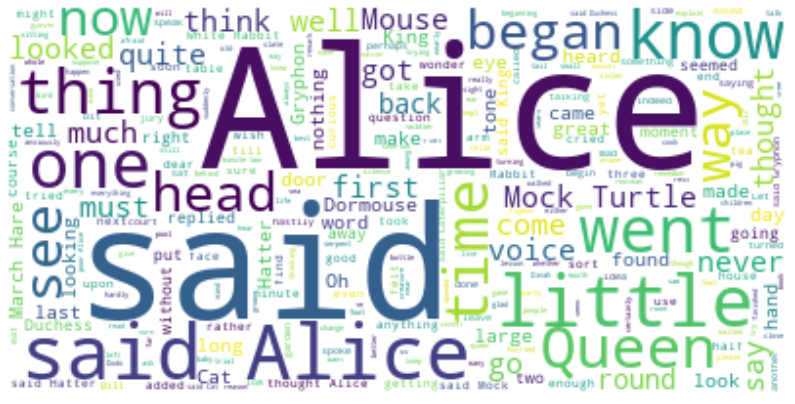

In [29]:
fig = plt.figure()
fig.set_figwidth(14) # set width
fig.set_figheight(18) # set height

# display the cloud
plt.imshow(alice_wc, interpolation='bilinear')
plt.axis('off')
plt.show()

Much better! However, **said** isn't really an informative word. So let's add it to our stopwords and re-generate the cloud.

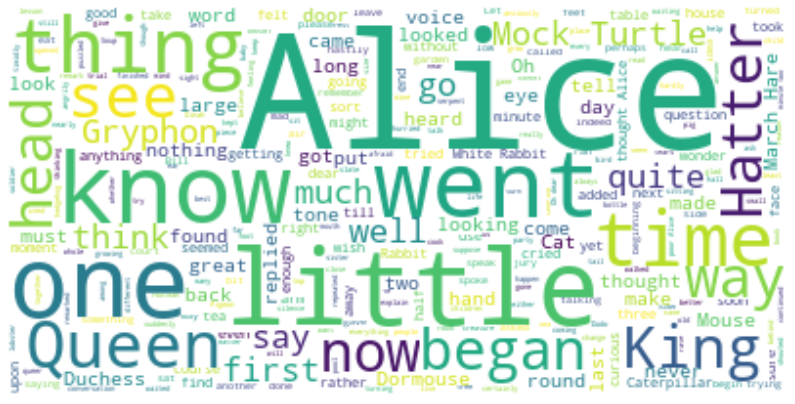

In [30]:
stopwords.add('said') # add the words said to stopwords

# re-generate the word cloud
alice_wc.generate(alice_novel)

# display the cloud
fig = plt.figure()
fig.set_figwidth(14) # set width
fig.set_figheight(18) # set height

plt.imshow(alice_wc, interpolation='bilinear')
plt.axis('off')
plt.show()

Excellent! This looks really interesting! Another cool thing you can implement with the `word_cloud` package is superimposing the words onto a mask of any shape. Let's use a mask of Alice and her rabbit. We already created the mask for you, so let's go ahead and download it and call it *alice_mask.png*.

In [31]:
# download image
!wget --quiet https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/DV0101EN/labs/Images/alice_mask.png
    
# save mask to alice_mask
alice_mask = np.array(Image.open('alice_mask.png'))
    
print('Image downloaded and saved!')

Image downloaded and saved!


Let's take a look at how the mask looks like.

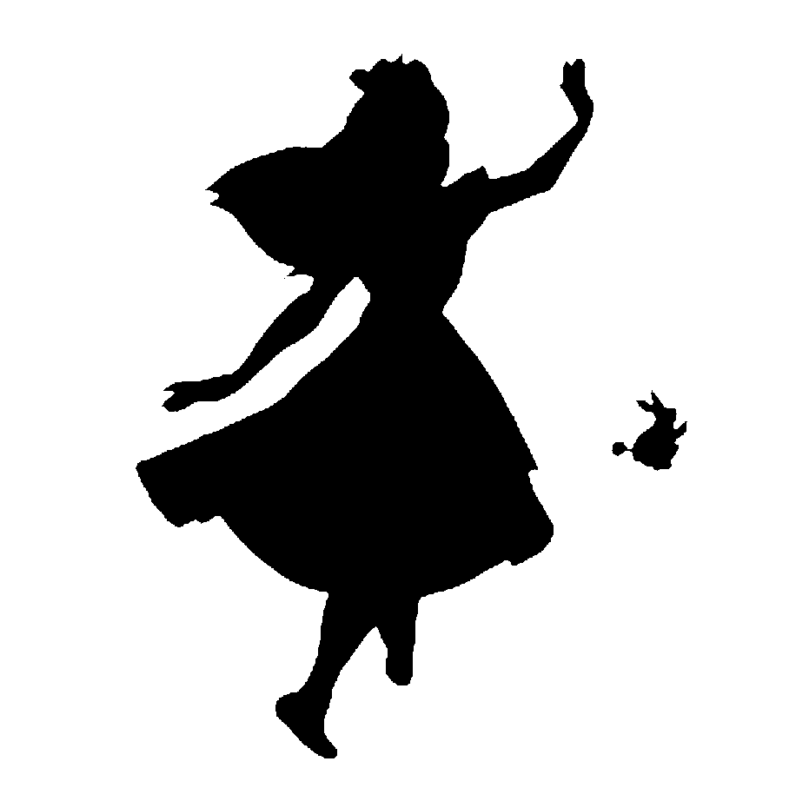

In [32]:
fig = plt.figure()
fig.set_figwidth(14) # set width
fig.set_figheight(18) # set height

plt.imshow(alice_mask, cmap=plt.cm.gray, interpolation='bilinear')
plt.axis('off')
plt.show()

Shaping the `word` cloud according to the mask is straightforward using `word_cloud` package. For simplicity, we will continue using the first 2000 words in the novel.

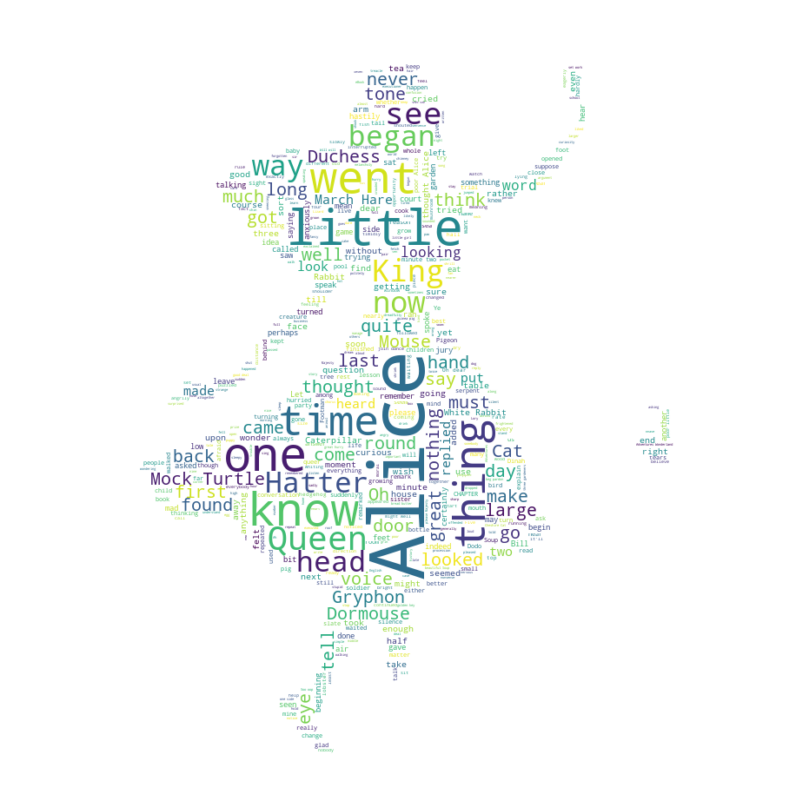

In [33]:
# instantiate a word cloud object
alice_wc = WordCloud(background_color='white', max_words=2000, mask=alice_mask, stopwords=stopwords)

# generate the word cloud
alice_wc.generate(alice_novel)

# display the word cloud
fig = plt.figure()
fig.set_figwidth(14) # set width
fig.set_figheight(18) # set height

plt.imshow(alice_wc, interpolation='bilinear')
plt.axis('off')
plt.show()

Really impressive!

Unfortunately, our immmigration data does not have any text data, but where there is a will there is a way. Let's generate sample text data from our immigration dataset, say text data of 90 words.

Let's recall how our data looks like.

In [34]:
df_can.head()

,Continent,Region,DevName,1980,1981,1982,1983,1984,1985,1986,...,2005,2006,2007,2008,2009,2010,2011,2012,2013,Total
Country,,,,,,,,,,,,,,,,,,,,,
Afghanistan,Asia,Southern Asia,Developing regions,16,39,39,47,71,340,496,...,3436,3009,2652,2111,1746,1758,2203,2635,2004,58639
Albania,Europe,Southern Europe,Developed regions,1,0,0,0,0,0,1,...,1223,856,702,560,716,561,539,620,603,15699
Algeria,Africa,Northern Africa,Developing regions,80,67,71,69,63,44,69,...,3626,4807,3623,4005,5393,4752,4325,3774,4331,69439
American Samoa,Oceania,Polynesia,Developing regions,0,1,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,6
Andorra,Europe,Southern Europe,Developed regions,0,0,0,0,0,0,2,...,0,1,1,0,0,0,0,1,1,15


And what was the total immigration from 1980 to 2013?

In [35]:
total_immigration = df_can['Total'].sum()
total_immigration

6409153

Using countries with single-word names, let's duplicate each country's name based on how much they contribute to the total immigration.

In [36]:
max_words = 90
word_string = ''
for country in df_can.index.values:
    # check if country's name is a single-word name
    if len(country.split(' ')) == 1:
        repeat_num_times = int(df_can.loc[country, 'Total']/float(total_immigration)*max_words)
        word_string = word_string + ((country + ' ') * repeat_num_times)
                                     
# display the generated text
word_string

'China China China China China China China China China Colombia Egypt France Guyana Haiti India India India India India India India India India Jamaica Lebanon Morocco Pakistan Pakistan Pakistan Philippines Philippines Philippines Philippines Philippines Philippines Philippines Poland Portugal Romania '

We are not dealing with any stopwords here, so there is no need to pass them when creating the word cloud.

In [37]:
# create the word cloud
wordcloud = WordCloud(background_color='white').generate(word_string)

print('Word cloud created!')

Word cloud created!


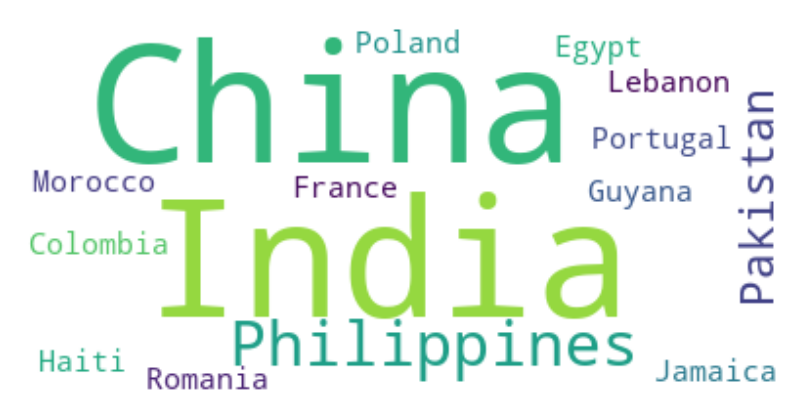

In [38]:
# display the cloud
fig = plt.figure()
fig.set_figwidth(14)
fig.set_figheight(18)

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

According to the above word cloud, it looks like the majority of the people who immigrated came from one of 15 countries that are displayed by the word cloud. One cool visual that you could build, is perhaps using the map of Canada and a mask and superimposing the word cloud on top of the map of Canada. That would be an interesting visual to build!

# Regression Plots <a id="10"></a>


> Seaborn is a Python visualization library based on matplotlib. It provides a high-level interface for drawing attractive statistical graphics. You can learn more about *seaborn* by following this [link](https://seaborn.pydata.org/) and more about *seaborn* regression plots by following this [link](http://seaborn.pydata.org/generated/seaborn.regplot.html).

In lab *Pie Charts, Box Plots, Scatter Plots, and Bubble Plots*, we learned how to create a scatter plot and then fit a regression line. It took ~20 lines of code to create the scatter plot along with the regression fit. In this final section, we will explore *seaborn* and see how efficient it is to create regression lines and fits using this library!

Let's first install *seaborn*

In [39]:
# install seaborn
!conda install -c anaconda seaborn --yes

# import library
import seaborn as sns

print('Seaborn installed and imported!')

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.5.11
  latest version: 4.7.10

Please update conda by running

    $ conda update -n base -c defaults conda



## Package Plan ##

  environment location: /home/jupyterlab/conda/envs/python

  added / updated specs: 
    - seaborn


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    matplotlib-3.1.0           |   py36h5429711_0         6.7 MB  anaconda
    seaborn-0.9.0              |           py36_0         379 KB  anaconda
    sip-4.19.13                |   py36he6710b0_0         293 KB  anaconda
    pyqt-5.9.2                 |   py36h22d08a2_1         5.6 MB  anaconda
    ------------------------------------------------------------
                                           Total:        12.9 MB

The following packages will be UPDATED:

    matplotlib: 2.2.3-py37hb69df0a_0              --

Create a new dataframe that stores that total number of landed immigrants to Canada per year from 1980 to 2013.

In [40]:
# we can use the sum() method to get the total population per year
df_tot = pd.DataFrame(df_can[years].sum(axis=0))

# change the years to type float (useful for regression later on)
df_tot.index = map(float, df_tot.index)

# reset the index to put in back in as a column in the df_tot dataframe
df_tot.reset_index(inplace=True)

# rename columns
df_tot.columns = ['year', 'total']

# view the final dataframe
df_tot.head()

,year,total
0,1980.0,99137
1,1981.0,110563
2,1982.0,104271
3,1983.0,75550
4,1984.0,73417


With *seaborn*, generating a regression plot is as simple as calling the **regplot** function.

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


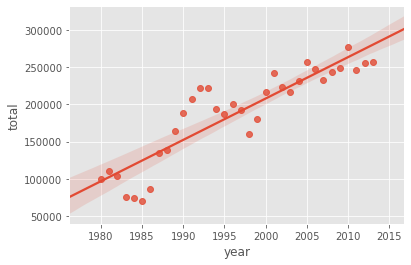

In [41]:
import seaborn as sns
ax = sns.regplot(x='year', y='total', data=df_tot)

This is not magic; it is *seaborn*! You can also customize the color of the scatter plot and regression line. Let's change the color to green.

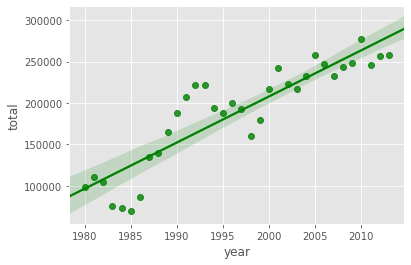

In [42]:
import seaborn as sns
ax = sns.regplot(x='year', y='total', data=df_tot, color='green')

You can always customize the marker shape, so instead of circular markers, let's use '+'.

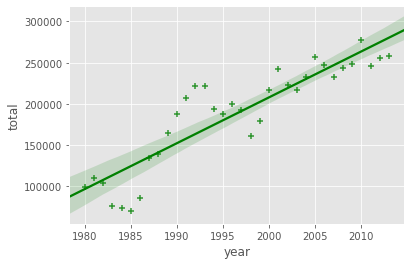

In [43]:
import seaborn as sns
ax = sns.regplot(x='year', y='total', data=df_tot, color='green', marker='+')

Let's blow up the plot a little bit so that it is more appealing to the sight.

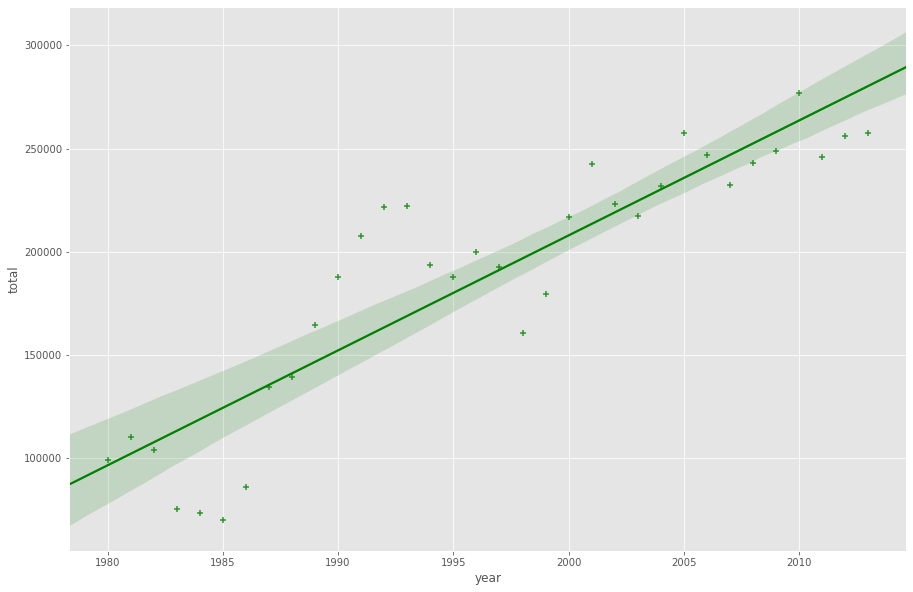

In [44]:
plt.figure(figsize=(15, 10))
ax = sns.regplot(x='year', y='total', data=df_tot, color='green', marker='+')

And let's increase the size of markers so they match the new size of the figure, and add a title and x- and y-labels.

Text(0.5, 1.0, 'Total Immigration to Canada from 1980 - 2013')

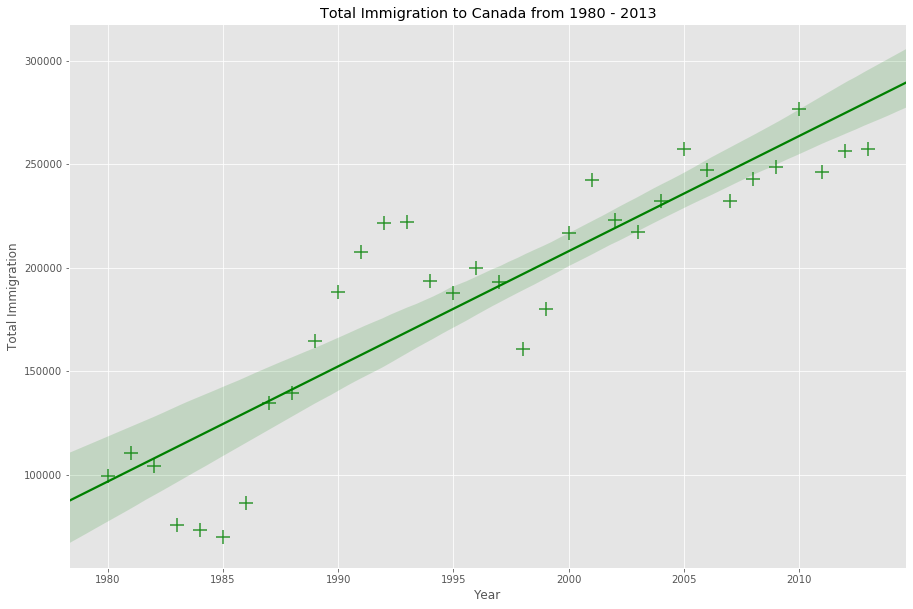

In [45]:
plt.figure(figsize=(15, 10))
ax = sns.regplot(x='year', y='total', data=df_tot, color='green', marker='+', scatter_kws={'s': 200})

ax.set(xlabel='Year', ylabel='Total Immigration') # add x- and y-labels
ax.set_title('Total Immigration to Canada from 1980 - 2013') # add title

And finally increase the font size of the tickmark labels, the title, and the x- and y-labels so they don't feel left out!

Text(0.5, 1.0, 'Total Immigration to Canada from 1980 - 2013')

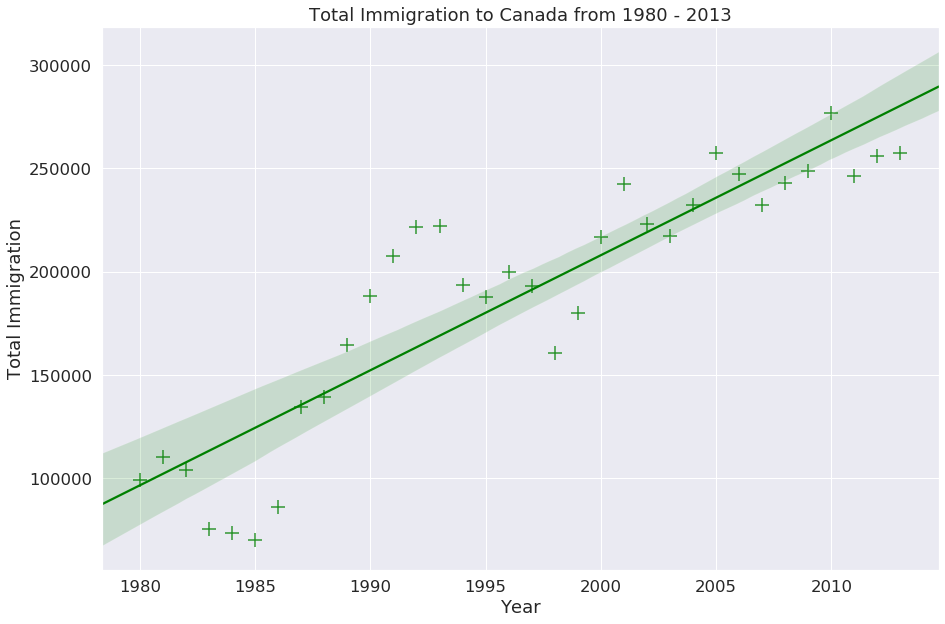

In [46]:
plt.figure(figsize=(15, 10))

sns.set(font_scale=1.5)

ax = sns.regplot(x='year', y='total', data=df_tot, color='green', marker='+', scatter_kws={'s': 200})
ax.set(xlabel='Year', ylabel='Total Immigration')
ax.set_title('Total Immigration to Canada from 1980 - 2013')

Amazing! A complete scatter plot with a regression fit with 5 lines of code only. Isn't this really amazing?

If you are not a big fan of the purple background, you can easily change the style to a white plain background.

Text(0.5, 1.0, 'Total Immigration to Canada from 1980 - 2013')

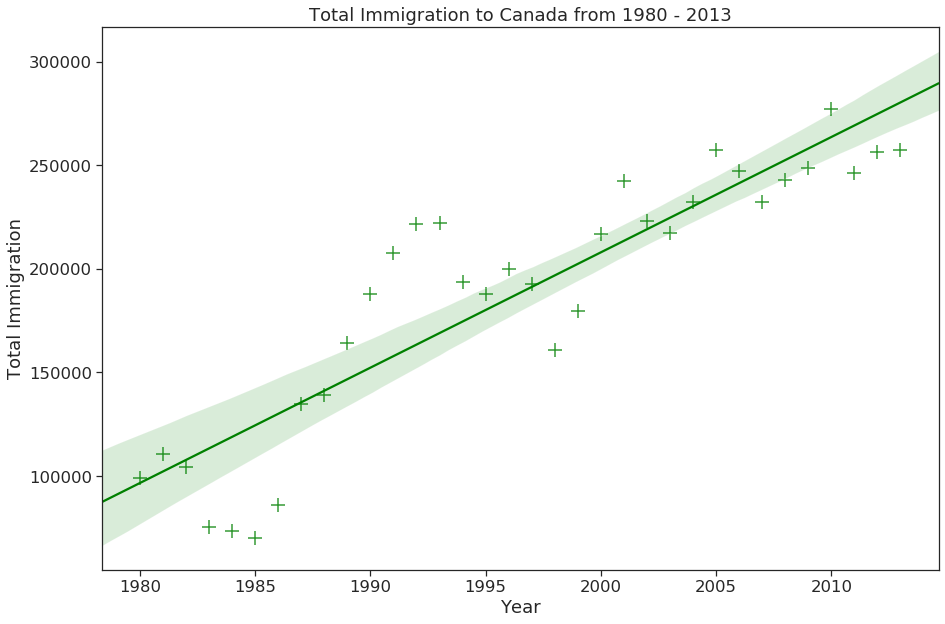

In [47]:
plt.figure(figsize=(15, 10))

sns.set(font_scale=1.5)
sns.set_style('ticks') # change background to white background

ax = sns.regplot(x='year', y='total', data=df_tot, color='green', marker='+', scatter_kws={'s': 200})
ax.set(xlabel='Year', ylabel='Total Immigration')
ax.set_title('Total Immigration to Canada from 1980 - 2013')

Or to a white background with gridlines.

Text(0.5, 1.0, 'Total Immigration to Canada from 1980 - 2013')

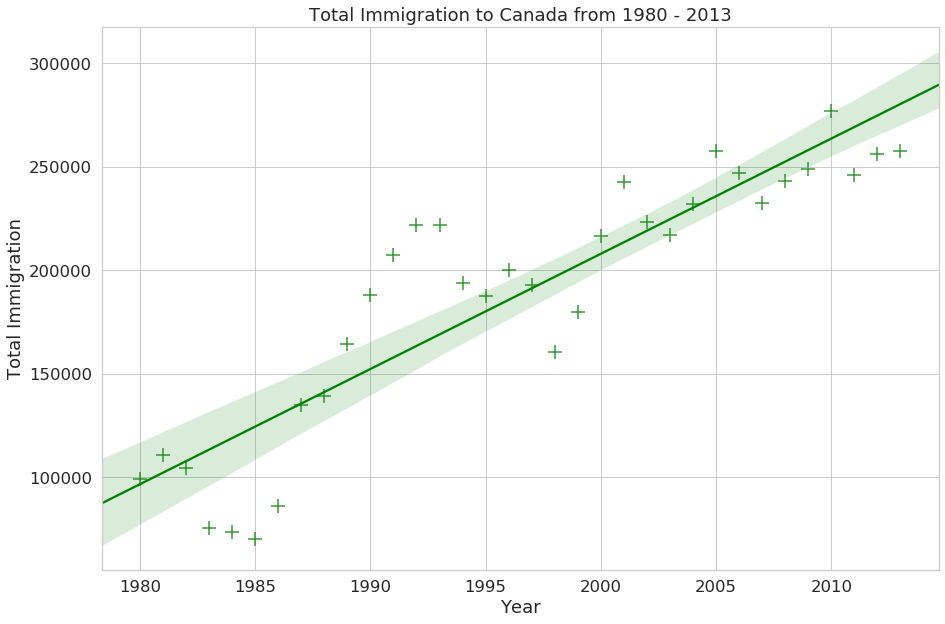

In [48]:
plt.figure(figsize=(15, 10))

sns.set(font_scale=1.5)
sns.set_style('whitegrid')

ax = sns.regplot(x='year', y='total', data=df_tot, color='green', marker='+', scatter_kws={'s': 200})
ax.set(xlabel='Year', ylabel='Total Immigration')
ax.set_title('Total Immigration to Canada from 1980 - 2013')

**Question**: Use seaborn to create a scatter plot with a regression line to visualize the total immigration from Denmark, Sweden, and Norway to Canada from 1980 to 2013.

Text(0.5, 1.0, 'Total Immigrationn from Denmark, Sweden, and Norway to Canada from 1980 - 2013')

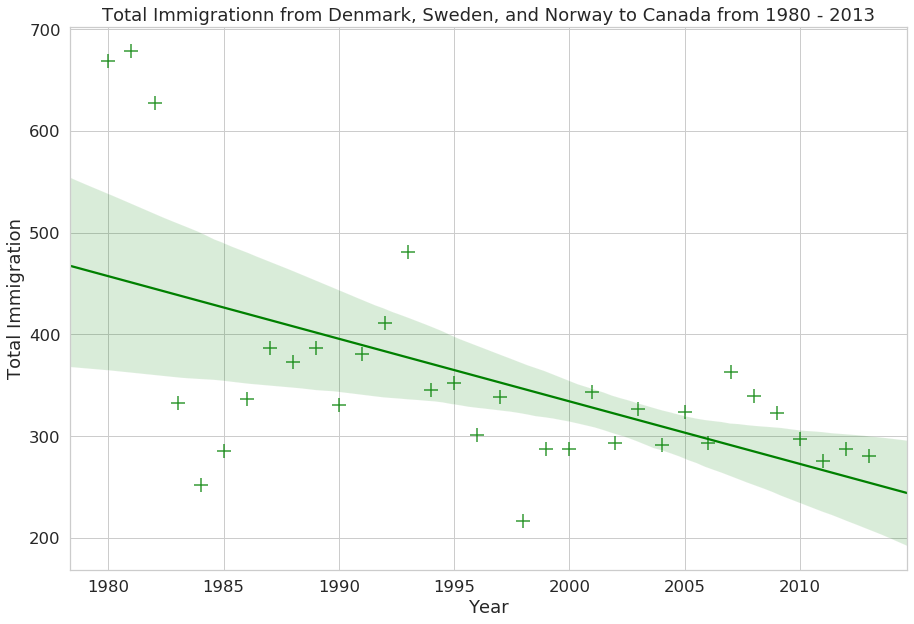

In [49]:


 # create df_countries dataframe
df_countries = df_can.loc[['Denmark', 'Norway', 'Sweden'], years].transpose()

# create df_total by summing across three countries for each year
df_total = pd.DataFrame(df_countries.sum(axis=1))

 # reset index in place
df_total.reset_index(inplace=True)
# rename columns
df_total.columns = ['year', 'total']

# change column year from string to int to create scatter plot
df_total['year'] = df_total['year'].astype(int)

# define figure size
plt.figure(figsize=(15, 10))

# define background style and font size
sns.set(font_scale=1.5)
sns.set_style('whitegrid')

# generate plot and add title and axes labels
ax = sns.regplot(x='year', y='total', data=df_total, color='green', marker='+', scatter_kws={'s': 200})
ax.set(xlabel='Year', ylabel='Total Immigration')
ax.set_title('Total Immigrationn from Denmark, Sweden, and Norway to Canada from 1980 - 2013')


Double-click __here__ for the solution.
<!-- The correct answer is:
\\ # create df_countries dataframe
df_countries = df_can.loc[['Denmark', 'Norway', 'Sweden'], years].transpose()
-->

<!--
\\ # create df_total by summing across three countries for each year
df_total = pd.DataFrame(df_countries.sum(axis=1))
-->

<!--
\\ # reset index in place
df_total.reset_index(inplace=True)
-->

<!--
\\ # rename columns
df_total.columns = ['year', 'total']
-->

<!--
\\ # change column year from string to int to create scatter plot
df_total['year'] = df_total['year'].astype(int)
-->

<!--
\\ # define figure size
plt.figure(figsize=(15, 10))
-->

<!--
\\ # define background style and font size
sns.set(font_scale=1.5)
sns.set_style('whitegrid')
-->

<!--
\\ # generate plot and add title and axes labels
ax = sns.regplot(x='year', y='total', data=df_total, color='green', marker='+', scatter_kws={'s': 200})
ax.set(xlabel='Year', ylabel='Total Immigration')
ax.set_title('Total Immigrationn from Denmark, Sweden, and Norway to Canada from 1980 - 2013')
-->

### Thank you for completing this lab!

This notebook was created by [Alex Aklson](https://www.linkedin.com/in/aklson/). I hope you found this lab interesting and educational. Feel free to contact me if you have any questions!

This notebook is part of a course on **Coursera** called *Data Visualization with Python*. If you accessed this notebook outside the course, you can take this course online by clicking [here](http://cocl.us/DV0101EN_Coursera_Week3_LAB1).

<hr>

Copyright &copy; 2019 [Cognitive Class](https://cognitiveclass.ai/?utm_source=bducopyrightlink&utm_medium=dswb&utm_campaign=bdu). This notebook and its source code are released under the terms of the [MIT License](https://bigdatauniversity.com/mit-license/).